In [1]:
##########################################
## this script is using the d2.5 - d5 scRNA-seq after regressing out the cell-cycle scores
## 
##########################################

In [2]:
import os, sys
#!{sys.executable} -m pip -q install palantir fa2
import warnings
warnings.filterwarnings("ignore")

In [3]:
# to avoid any possible jupyter crashes due to rpy2 not finding the R install on conda
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

In [4]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir

In [5]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"

sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

In [6]:
import matplotlib.pyplot as plt

In [7]:
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
sc.set_figure_params()
scf.set_figure_pubready()

In [8]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [9]:
data_dir = "../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d5_TFs_SPs_metacell_v1/"
outDir = data_dir
sc.settings.figdir = os.path.join(outDir, "figures/")

In [10]:
file_path = os.path.join(data_dir, "RNAmatrix_RA_TFs_SPs_regressedCellCycled2.5_d5_TFs_SPs_metacell_v1.h5ad")

In [11]:
import matplotlib
print(matplotlib.matplotlib_fname())

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


In [11]:
## import Rory's funcitons from https://github.com/rorymaizels/Maizels2023aa/blob/main/analysis/A2.2_benchmarking/A2.2.1_making_benchmark_datasets.ipynb
from cellrank.kernels import PseudotimeKernel
def process_for_pseudotime(adata, layer, n_neighbors=50):
    X = adata.layers[layer]
    X = X.A if issparse(X) else X
    
    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)
    adata.obsm['X_pca'] = Xpca
    adata.varm['precomputed_PCs'] = pca.components_
    
    if n_neighbors > 0:
        cnx = vt.pp.connectivities(total=X, n_neighbors=n_neighbors)
        Xsmooth = vt.pp.moments(X=X, cnx=cnx, n_neighbors=n_neighbors)
        Xlogsmooth = np.log1p(Xsmooth)
        pca = PCA()
        Xpcasmooth = pca.fit_transform(Xlogsmooth)
        adata.obsm['X_pca_smooth'] = Xpcasmooth
    else:
        adata.obsm['X_pca_smooth'] = Xpca
    return adata

def run_tree(
    adata, 
    layer,
    n_nodes=200,
    seed=1,
    ppt_lambda=50,
    ppt_sigma=1.5,
    ndims_rep=50,
    figsize=(9,4),
    dimensions=[[0,1],[0,2]],
    color='cell_annotation'
    ):
    scf.tl.tree(adata, method="ppt",Nodes=n_nodes, use_rep="X_pca_smooth",
                device="cpu",seed=seed,ppt_lambda=ppt_lambda,ppt_sigma=ppt_sigma,
                ppt_nsteps=300, ndims_rep=ndims_rep)
    fig = plt.figure(figsize=figsize)
    ax1, ax2 = fig.subplots(1,2)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax1, dimensions=dimensions[0], show=False, forks=False)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax2, dimensions=dimensions[1], show=False, forks=False)
    print(f"Tips: {adata.uns['graph']['tips']}")
    print()
    print(f"Forks: {adata.uns['graph']['forks']}")
    plt.show()

def run_pseudotime(adata, root, n_maps=10):    
    scf.tl.root(
        adata,
        root
    )

    scf.tl.pseudotime(
        adata,
        n_jobs=20,
        n_map=n_maps,
        seed=42
    )
    adata.obs['seg'] = adata.obs['seg'].astype('category')
    scf.pl.trajectory(adata, basis='pca', color_cells='seg')

def get_cell_pseudotime_vector(adata, cell_idx, basis='pca', ndim=50):
    idx = adata.uns['graph']['pp_info'].sort_values('time').PP.values
    points = adata.uns['graph']['F'].T[idx]
    segs = adata.uns['graph']['pp_info'].seg.values[idx]
    
    
    cell = adata[cell_idx]
    cell_rep = cell.obsm[f'X_{basis}'][:,:ndim]
    cell_seg = cell.obs.seg.values[0]
    
    seg_points = points[segs==cell_seg][:,:ndim]
    best = np.sqrt(np.sum((cell_rep - seg_points)**2, axis=1)).argmin()
    try:
        vector = seg_points[best+1] - seg_points[best]
    except IndexError:
        vector = np.zeros_like(seg_points[best])
    return vector

def calculate_pseudotime_vectorfield(adata, ndim=50, basis='pca'):
    vf = np.zeros_like(adata.obsm[f"X_{basis}"][:,:ndim])
    for i in trange(adata.shape[0]):
        vf[i,:] = get_cell_pseudotime_vector(adata, cell_idx=i, basis=basis, ndim=ndim)
    adata.obsm['velocity_pst'] = vf
    adata.obsm['X_pst'] = adata.obsm[f"X_{basis}"][:,:ndim]
    
def viz(adata, genes):
    """
    we don't want to keep the log transformed data or PCA, but want to viz
    """
    copy = adata.copy()    
    sc.pp.log1p(copy)
    sc.pp.pca(copy)
    sc.pl.pca(copy, color=['cell_annotation','timepoint','rep'])
    
def calculate_cellrank_vectorfield(adata, ndim=50, basis='pca'):
    cnx = vt.pp.connectivities(total=adata.layers['total'], n_neighbors=30)
    adata.obsp['neighbors_connectivities'] = cnx
    pk = PseudotimeKernel(adata, time_key='t')
    pk.compute_transition_matrix()
    pk.plot_projection(basis='pca', key_added='velocity_cr')
    adata.obsm['X_cr_pca'] = adata.obsm[f"X_{basis}"][:,:ndim]

In [38]:
# Load sample data
adata = sc.read(file_path, chunk_size=6000)

In [39]:
## processing steps

In [40]:
#counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
#norm_df = sc.pp.normalize_per_cell(counts,copy=True)
#norm_df = palantir.preprocess.log_transform(norm_df)
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [41]:
adata.obsm["X_seurat_pca"] = adata.obsm["X_pca"]
adata.obsm["X_seurat_umap"] = adata.obsm["X_umap"]

In [42]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": [],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Comic Sans MS"],
})

In [43]:
import matplotlib as mpl
print(mpl.get_cachedir())

/users/jingkui.wang/.cache/matplotlib


In [44]:
# basic filtering from scanpy, original code from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
#sc.pl.highest_expr_genes(adata, n_top=20)
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=5)

In [45]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [46]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.normalize_per_cell(adata)
#palantir.preprocess.log_transform(adata)
#sc.pp.log1p(adata)

In [47]:
#adata=sc.AnnData(norm_df)
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger')
#sc.pp.pca(adata, n_comps = 50)

In [48]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [49]:
# test Rory's function, not used for the moment
#adata.layers['X']
#Xlog = np.log1p(adata)
#from sklearn.decomposition import PCA
#pca = PCA()
#Xpca = pca.fit_transform(Xlog)
#adata.obsm['X_pca'] = Xpca
#adata.varm['precomputed_PCs'] = pca.components_
#adata = process_for_pseudotime(adata, 'total')

In [50]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [51]:
pca_projections = pd.DataFrame(adata.obsm["X_seurat_pca"], index=adata.obs_names)

In [52]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components = 30)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [53]:
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=None)
ms_data

,0,1,2
1,-0.187302,0.104415,0.050058
2,-0.121675,0.105879,-0.009845
3,-0.355085,-0.448363,-0.073389
4,-0.315792,-0.348945,-0.056721
5,-0.215515,0.087949,-0.004591
...,...,...,...
691,-0.261883,0.247798,-0.002237
692,-0.101994,0.044169,0.060161
693,0.173433,-0.026891,-0.017250
694,-0.102952,-0.064086,0.055147


In [54]:
adata.obsm["X_palantir"]=ms_data.values

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:02)


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

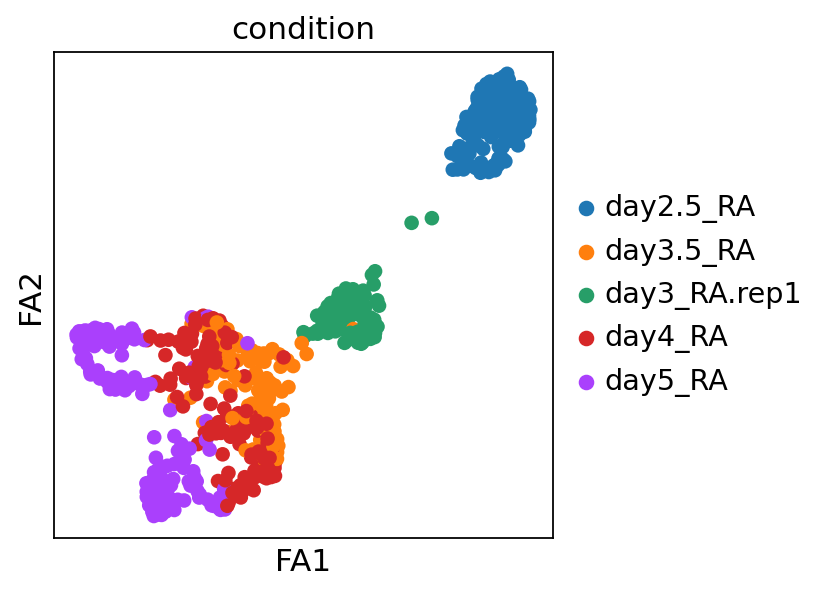

In [57]:
# generate neighbor draph in multiscale diffusion space
sc.pp.neighbors(adata, n_neighbors=30, 
                use_rep="X_seurat_pca", 
                n_pcs = 10)
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_seurat_umap"][:,:2]
sc.tl.draw_graph(adata, init_pos='X_pca2d')
sc.pl.draw_graph(adata, color="condition",color_map="RdBu_r")

In [30]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
# sc.pl.pca(adata, color=['condition'], components='2,3')

In [38]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [39]:
#Tree learning with SimplePPT

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.02, lambda = 100, metric = euclidean
    fitting:  16%|█▌        | 31/200 [00:00<00:02, 60.25it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

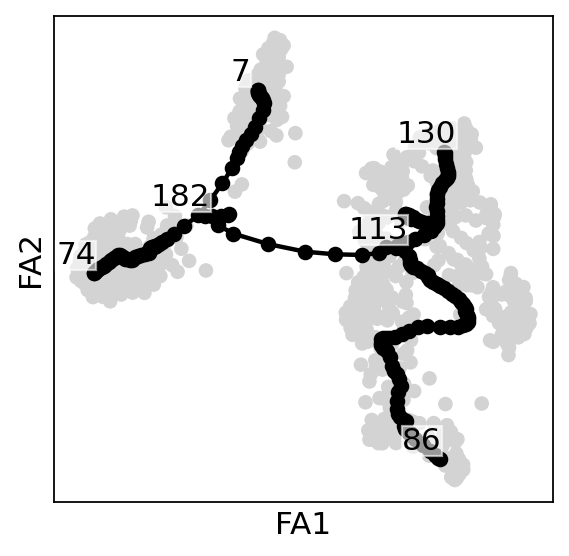

In [46]:
scf.tl.tree(adata, method="ppt", Nodes=200, use_rep="X_palantir", 
            ndims_rep=2,
            device="cpu",
            seed=1,
            ppt_lambda=100,
            ppt_sigma=0.02,
            ppt_nsteps=200)
# projecting results onto ForceAtlas2 embedding
#scf.pl.graph(adata, basis = 'umap')
scf.pl.graph(adata)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.01, lambda = 200, metric = euclidean
    fitting:  23%|██▎       | 46/200 [00:03<00:10, 14.51it/s]
    converged
    finished (0:00:03) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

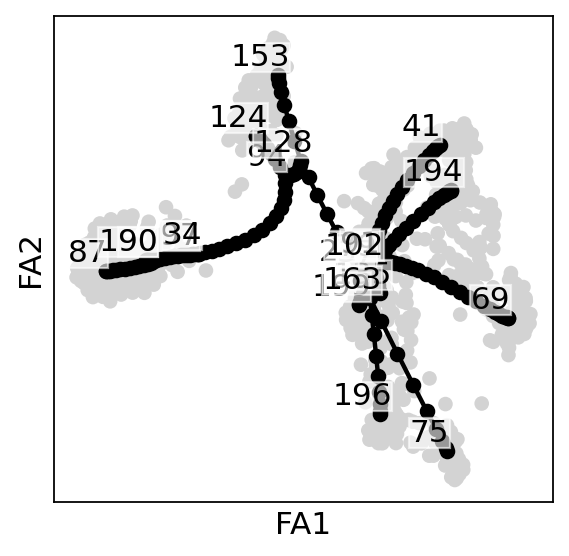

In [57]:
scf.tl.tree(adata, method="ppt", Nodes=200, use_rep="X_pca", 
            ndims_rep=30,
            device="cpu",
            seed=1,
            ppt_lambda=200,
            ppt_sigma=0.01,
            ppt_nsteps=200)
# projecting results onto ForceAtlas2 embedding
#scf.pl.graph(adata, basis = 'umap')
scf.pl.graph(adata)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.7, lambda = 200, metric = euclidean
    fitting:  13%|█▎        | 26/200 [00:02<00:13, 12.67it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

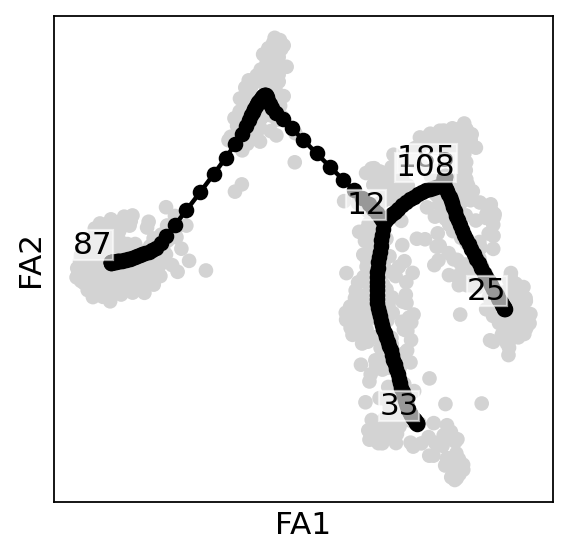

In [59]:
scf.tl.tree(adata, method="ppt", Nodes=200, use_rep="X_seurat_umap", 
            ndims_rep=20,
            device="cpu",
            seed=1,
            ppt_lambda=200,
            ppt_sigma=0.7,
            ppt_nsteps=200)

# projecting results onto ForceAtlas2 embedding
scf.pl.graph(adata)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

    graph cleaned --> removed 11 principal points


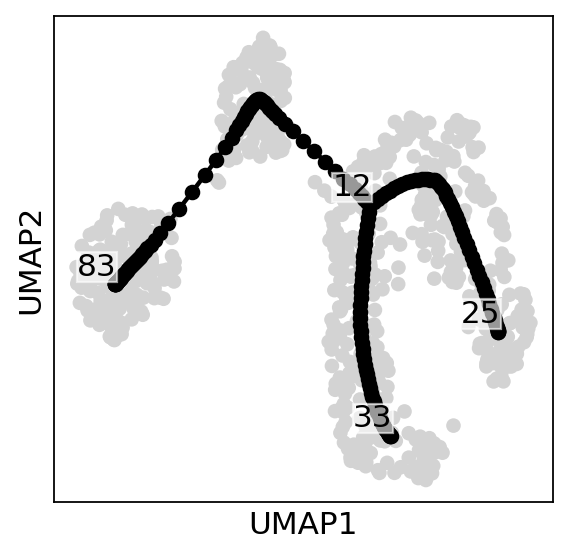

In [61]:
scf.tl.cleanup(adata,minbranchlength=20);
scf.pl.graph(adata, basis = 'umap')

In [62]:
# Selecting a root and computing pseudotime
# Using CD34 marker, we can confidently tell that the tip 163 is the root.
scf.tl.root(adata, 83)

node 83 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [63]:
# Here we are going to generate 100 mappings of pseudotime, to account for cell asssignment uncertainty. 
# to .obs will be saved the mean of all calculated pseudotimes.
# exmaple data takes > 360G memory and 16 nodes
scf.tl.pseudotime(adata, seed=42, n_jobs=20, n_map=100)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
    finished (0:00:32) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [64]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors', 'graph', 'ppt', 'pseudotime_list', 'milestones_colors', 'seg_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa', 'X_R'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [65]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir, 'scFates_pseudotime_mNT_d2.5_d5.h5ad'), compression="gzip")

In [66]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5.h5ad'),chunk_size=6000)

In [67]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'condition_colors', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors'
    obsm: 'X_R', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

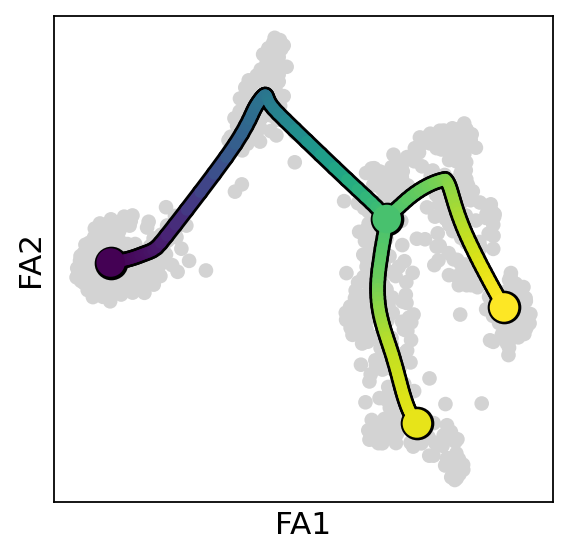

In [68]:
# Representing the trajectory and tree on top of existing embedding
scf.pl.trajectory(adata)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' 

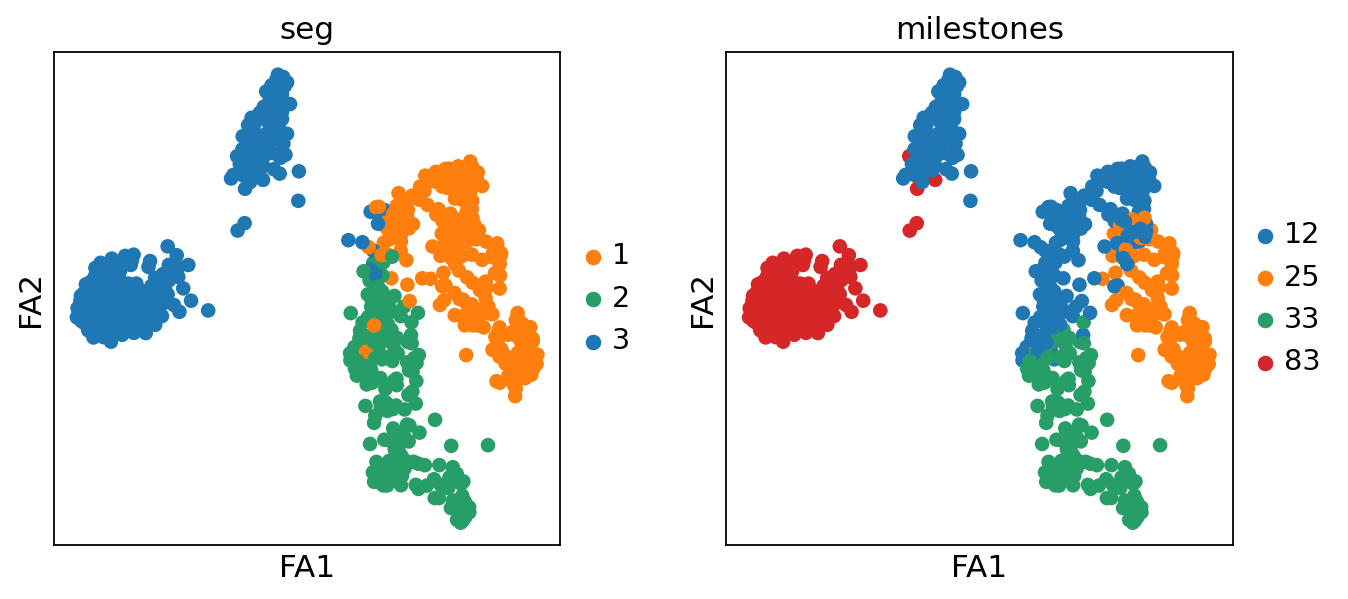

In [69]:
sc.pl.draw_graph(adata,color=["seg","milestones"])

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

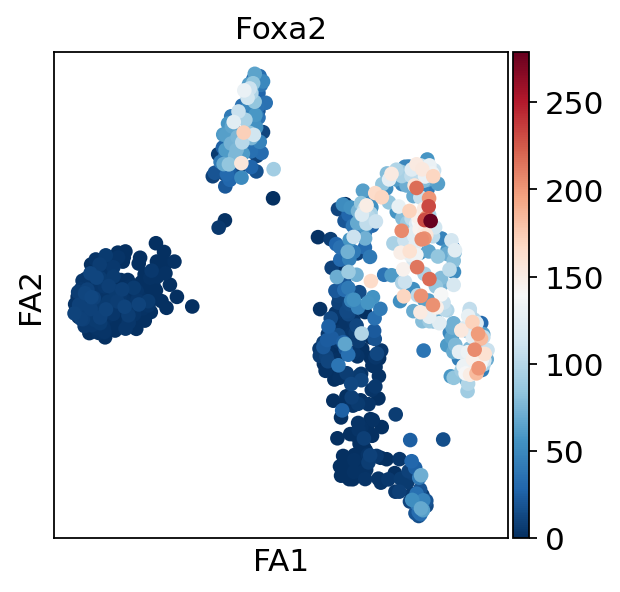

In [70]:
sc.pl.draw_graph(adata, color="Foxa2",color_map="RdBu_r")

In [71]:
scf.tl.rename_milestones(adata,["Bifu", "FP", "NP", "Root"])
# we change the color of the root milestone for better visualisations
#adata.uns["milestones_colors"][3]="#17bece"

In [72]:
from pathlib import Path
Path(os.path.join(outDir, "figures/")).mkdir(parents=True, exist_ok=True)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


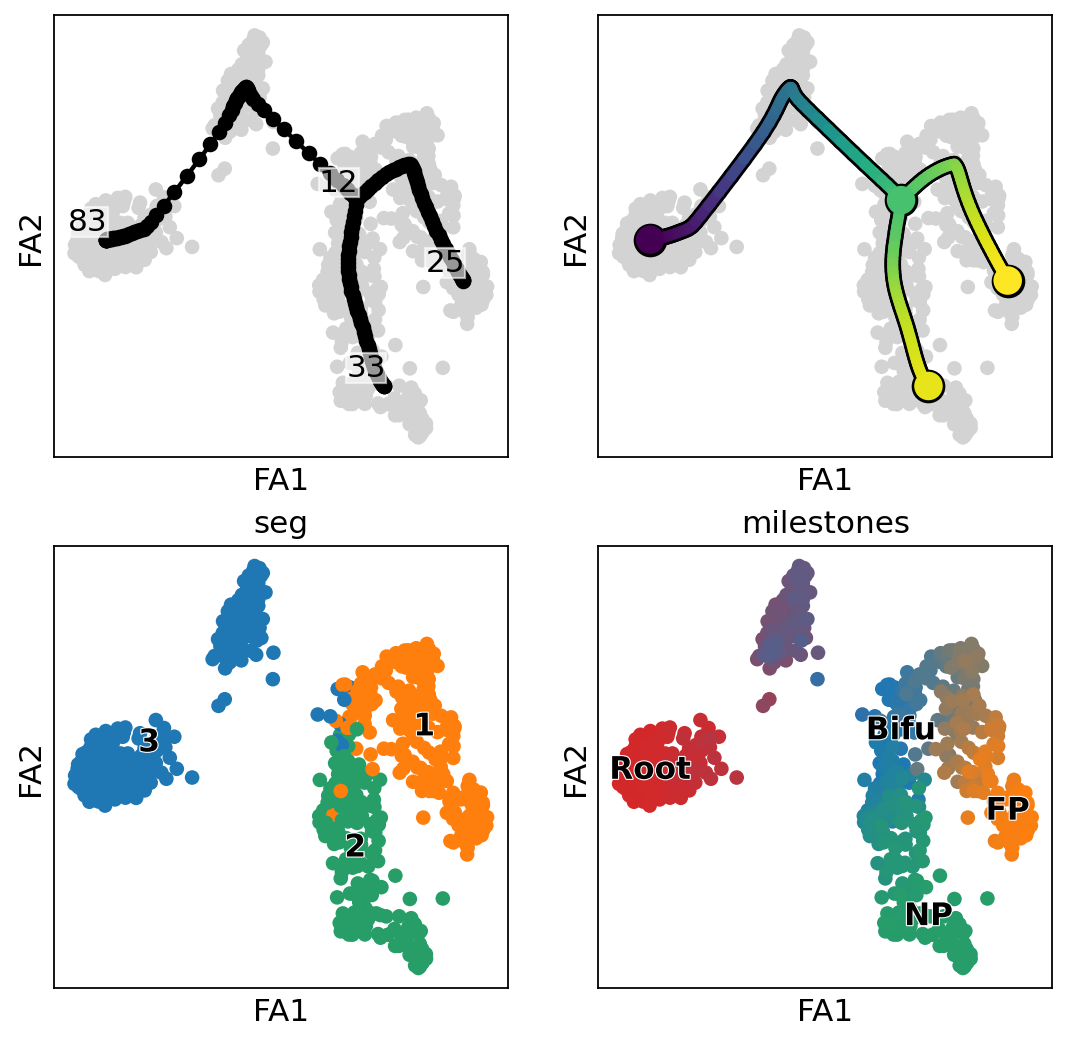

In [73]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1])
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)
plt.savefig(os.path.join(outDir, "figures/A.pdf"),dpi=300)

In [74]:
# as a dendrogram representation (take some 5-10 minutes)
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|██████████| 3/3 [00:00<00:00, 20.64it/s]
    finished (0:00:00) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

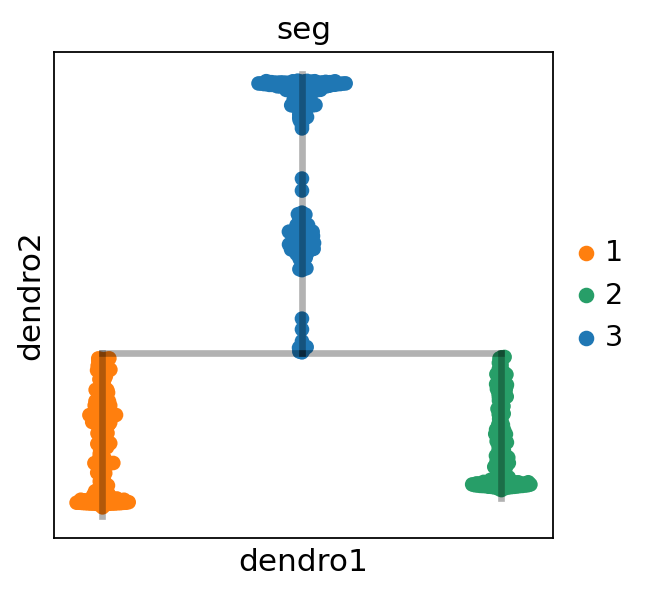

In [75]:
scf.pl.dendrogram(adata,color="seg")

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

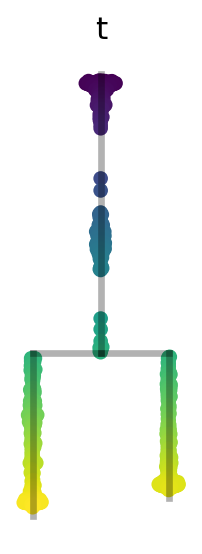

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

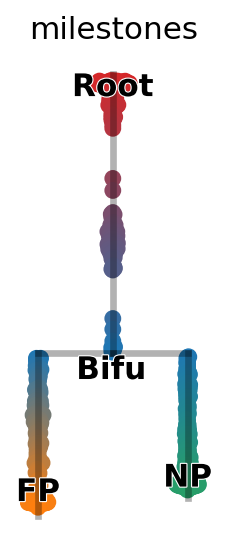

In [76]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,
                  save="B1.pdf",
                  cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",
                  color_milestones=True,legend_fontoutline=True, 
                  save="B2.pdf")


In [77]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_before.test.asssociation.h5ad'), compression="gzip")

In [12]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_before.test.asssociation.h5ad'),chunk_size=6000)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic f

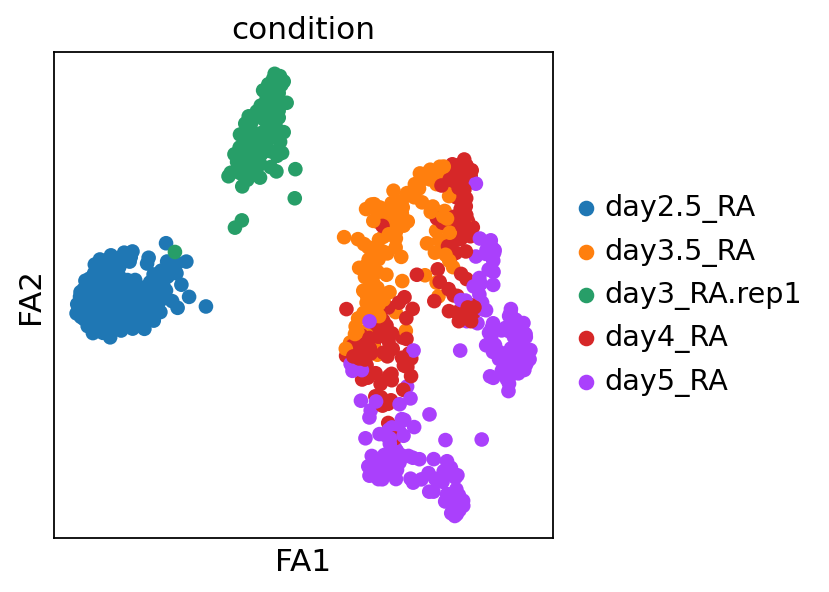

In [13]:
sc.pl.draw_graph(adata, color="condition",color_map="RdBu_r")

In [181]:
# Test and fit features associated with the tree
scf.tl.test_association(adata,n_jobs=20, A_cut=0.5)

test features for association with the trajectory
    single mapping : 100%|██████████| 2001/2001 [00:30<00:00, 65.99it/s]
    found 228 significant features (0:00:30) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [182]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_v4.h5ad'), compression="gzip")

In [183]:
#adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'),chunk_size=6000)
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_v4.h5ad'),chunk_size=6000)

In [184]:
outDir 

'../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d5_TFs_SPs_metacell_v1/'

In [185]:
#outDir = "../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d6_noMatureNeuron_filteredCellCycleGenes_v1.2/"
sc.settings.figdir = os.path.join(outDir, "figures/")

In [186]:
adata

AnnData object with n_obs × n_vars = 695 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

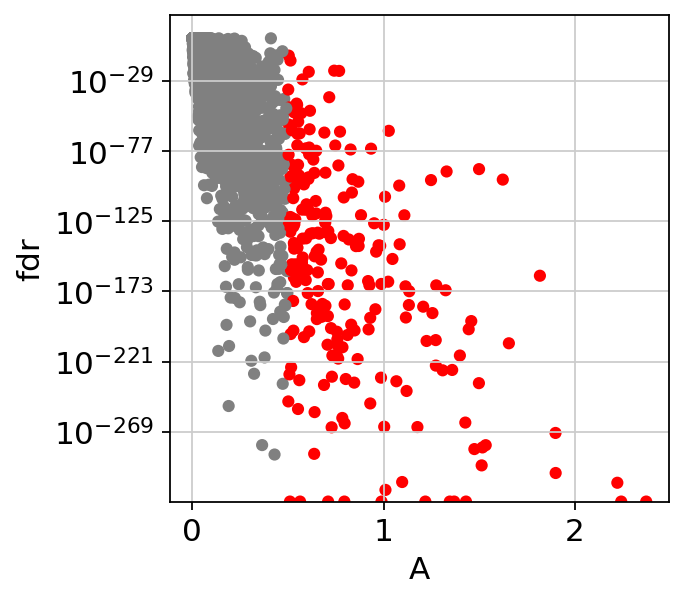

In [187]:
sc.set_figure_params()
scf.pl.test_association(adata)
plt.savefig("figures/C_v2.pdf",dpi=300)

In [188]:
scf.tl.fit(adata, n_jobs=20, gamma = 20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 228/228 [00:01<00:00, 171.85it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:01) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

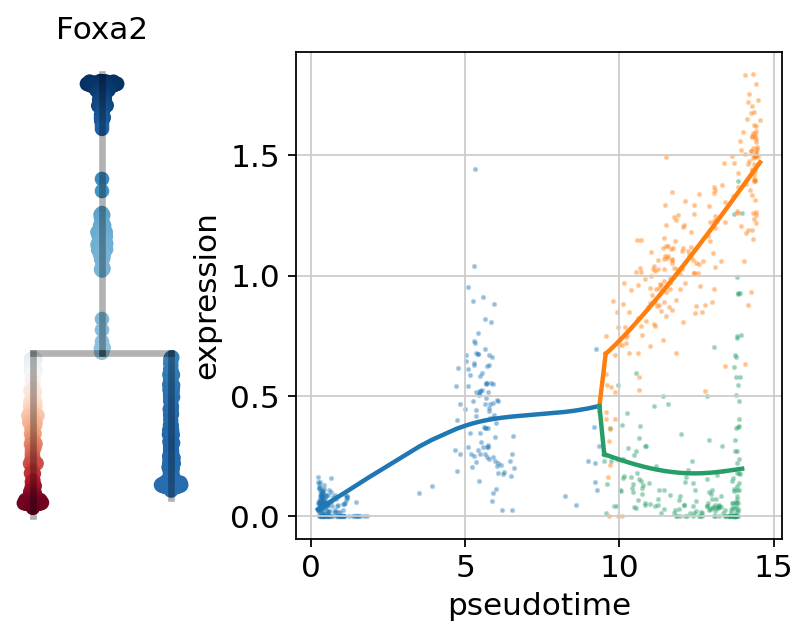

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

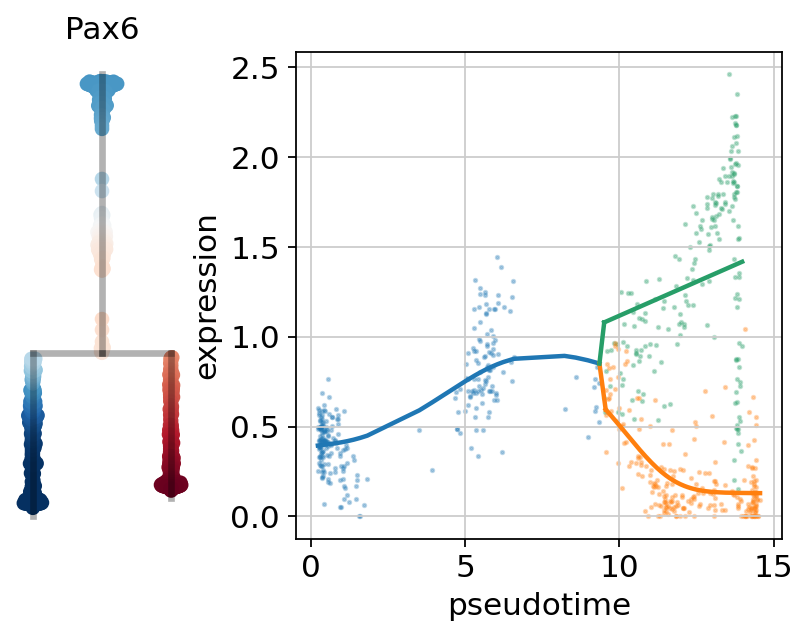

In [189]:
# Plotting single features
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"Foxa2",basis="dendro",wspace=-.25,save="_E1.pdf")
scf.pl.single_trend(adata,"Pax6",basis="dendro",wspace=-.25,save="_E2.pdf")

In [190]:
outDir

'../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d5_TFs_SPs_metacell_v1/'

In [191]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_v4_trajectory_fit.h5ad'), compression="gzip")

In [192]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_v4_trajectory_fit.h5ad'),chunk_size=6000)

In [193]:
adata.layers["fitted"]

array([[ 7.06740772e-01,  2.80721281e-01,  7.08089145e-01, ...,
         2.36964474e-01,  7.87661542e-03, -3.58564913e-02],
       [ 3.82396781e-01,  4.31605836e-01,  6.44685393e-01, ...,
         3.27325142e-01,  9.59392447e-03,  1.56837517e-01],
       [-1.36905564e-02,  5.22612097e-02,  6.42255542e-01, ...,
         4.66398597e-03,  2.65748825e-01,  1.92567609e-03],
       ...,
       [-2.00115192e-02,  4.95888419e-02,  6.41166254e-01, ...,
         4.54071920e-03,  2.79220798e-01,  1.92567609e-03],
       [ 1.63485647e-01,  3.95112204e-01,  1.42068341e+00, ...,
         1.68173221e-03,  9.41847349e-04,  1.19564659e-03],
       [ 7.12961360e-01,  2.76669890e-01,  7.12183525e-01, ...,
         2.23855405e-01,  7.78539604e-03, -3.68093467e-02]])

In [194]:
adata

AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [195]:
# All branches DE analysis
scf.tl.test_fork(adata,root_milestone="Root",milestones=["NP","FP"],n_jobs=20, rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 228/228 [00:00<00:00, 275.53it/s]
    test for upregulation for each leave vs root
    upreg FP: 100%|██████████| 144/144 [00:00<00:00, 783.46it/s]
    finished (0:00:01) --> added 
    .uns['Root->NP<>FP']['fork'], DataFrame with fork test results.


In [196]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_trajectory_fit_testFork_v4.h5ad'), compression="gzip")

In [197]:
# Bifurcation analysis

In [10]:
adata = sc.read_h5ad(os.path.join(outDir, 'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_trajectory_fit_testFork_v4.h5ad'),chunk_size=6000)

In [11]:
# test the thresholding parameters
effect = 0.3
scf.tl.branch_specific(adata,root_milestone="Root", milestones=["NP","FP"], effect= effect, copy = True)
#scf.tl.branch_specific(adata,root_milestone="Root",milestones=["NP", "FP"], effect=0.2)

    branch specific features: FP: 22, NP: 17
    finished --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'branch' column.


AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [12]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["NP", "FP"], effect= effect)

    branch specific features: FP: 22, NP: 17
    finished --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'branch' column.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

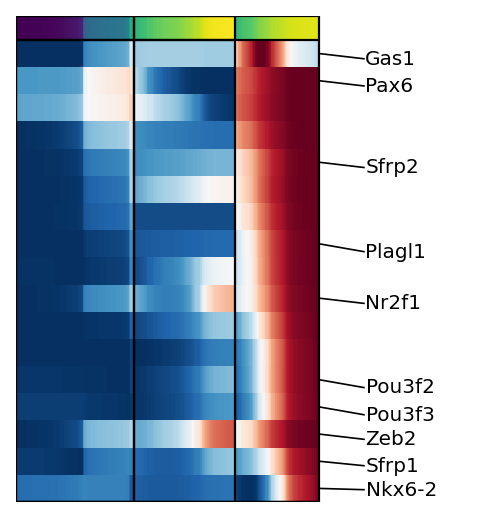

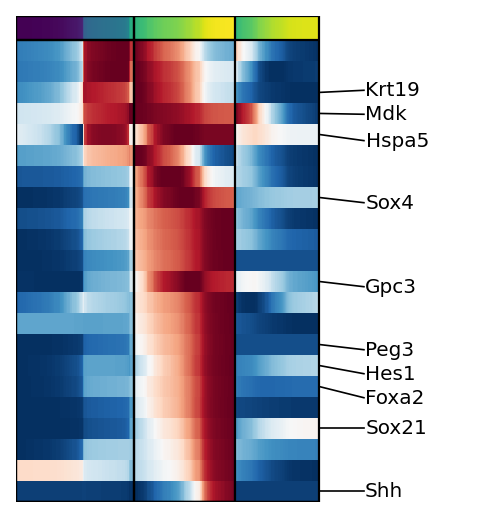

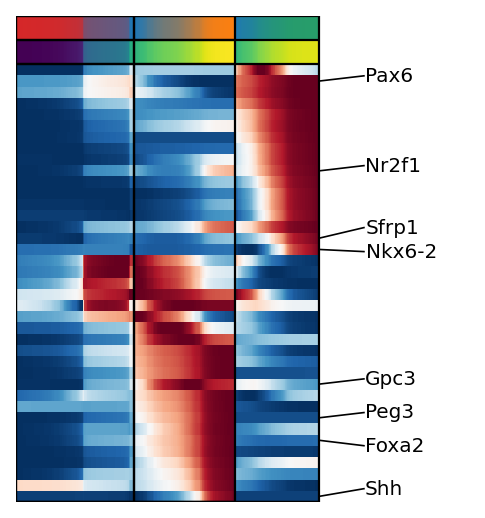

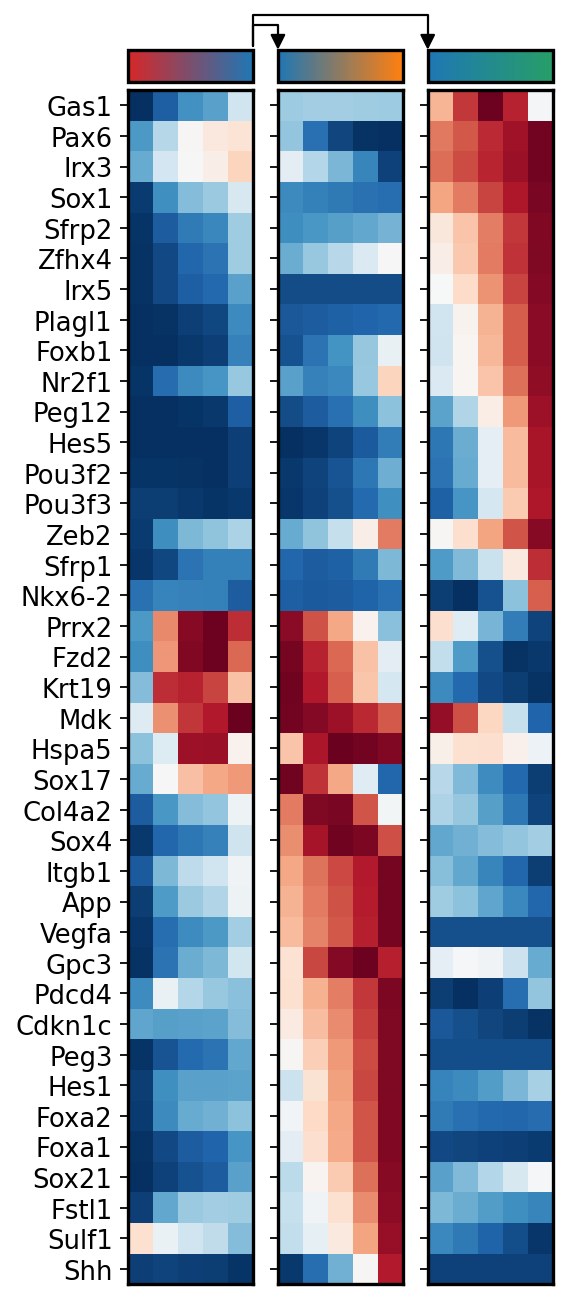

In [13]:
g1=scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["NP","FP"],
                 branch="NP",
                 plot_emb=False,ordering="max",return_genes=True);
g2=scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["NP", "FP"],
                 branch="FP",
                 plot_emb=False,ordering="max",return_genes=True);
gg=g1.tolist() + g2.tolist();
import matplotlib.pyplot as plt
g=scf.pl.trends(adata,gg,figsize=(4,4),annot="milestones",n_features=8,
        plot_emb=False,ordering=None,return_genes=True)
plt.savefig("figures/D.pdf",dpi=300);
# Displaying results using matrix plot
sc.set_figure_params()
scf.pl.matrix(adata,gg,norm="minmax",cmap="RdBu_r",colorbar=False,save="_F.pdf")

In [14]:
# Early gene detection

In [15]:
#scf.tl.activation_lm(adata,root_milestone="Root", milestones=["NP", "FP"], n_jobs=20)
scf.tl.activation_lm(adata, root_milestone="Root", milestones=["NP", "FP"], 
                     fdr_cut= 0.1,
                     #stf_cut = 0.8,
                     n_jobs = 20,
                     pseudotime_offset = 4.5,
                     copy = True
                    )

    single mapping
    prefork activation: 100%|██████████| 39/39 [02:53<00:00,  4.45s/it]
    3 early and 14 late features specific to leave NP
    17 early and 5 late features specific to leave FP
    finished (0:05:33) --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [216]:
scf.tl.activation_lm(adata, root_milestone="Root", milestones=["NP", "FP"], 
                     #fdr_cut= 0.5, 
                     pseudotime_offset = 4.5,
                     #stf_cut = 0.5,
                     n_jobs = 20,
                     copy = False
                    )

    single mapping
    prefork activation: 100%|██████████| 39/39 [00:00<00:00, 780.57it/s]
    2 early and 15 late features specific to leave NP
    17 early and 5 late features specific to leave FP
    finished (0:00:11) --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


In [217]:
adata

AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [218]:
adata.write(os.path.join(outDir,
                         'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_trajectory_fit_testFork_earlyLateModules.h5ad'), 
            compression="gzip")

In [102]:
adata = sc.read_h5ad(os.path.join(outDir, 
                                  'scFates_pseudotime_mNT_d2.5_d5_after.test.asssociation_trajectory_fit_testFork_earlyLateModules.h5ad'),
                     chunk_size=6000)

In [103]:
df = adata.uns["Root->NP<>FP"]["fork"]

In [104]:
## manually correct the early and late genes
df.index
df.loc["Gas1", 'module'] = 'early'
df.loc["Pax6", 'module'] = 'early'
df.loc["Irx3", 'module'] = 'early'
df.loc["Sox1", 'module'] = 'early'
df.loc["Sfrp2", 'module']
df.loc["Zfhx4", 'module']
df.loc["Irx5", 'module']
df.loc["Plagl1", 'module']
df.loc["Foxb1", 'module']
df.loc["Nr2f1", 'module'] = 'early'
df.loc["Peg12", 'module']
df.loc["Hes5", 'module']
df.loc["Pou3f3", 'module']
df.loc["Pou3f2", 'module']
df.loc["Zeb2", 'module']
df.loc["Sfrp1", 'module']
df.loc["Nkx6-2", 'module']
df.loc["Prrx2", 'module']
df.loc["Fzd2", 'module']
df.loc["Krt19", 'module']
df.loc["Mdk", 'module']
df.loc["Hspa5", 'module'] = 'early'
df.loc["Sox17", 'module'] = 'early'
df.loc["Col4a2", 'module'] = 'late'
df.loc["Sox4", 'module'] = 'late'
df.loc["Itgb1", 'module'] 
df.loc["App", 'module']
df.loc["Vegfa", 'module']
df.loc["Gpc3", 'module']
df.loc["Pdcd4", 'module']
df.loc["Cdkn1c", 'module'] = 'late'
df.loc["Peg3", 'module'] = 'late'
df.loc["Hes1", 'module']
df.loc["Foxa2", 'module']
df.loc["Foxa1", 'module'] = 'late'
df.loc["Sox21", 'module']
df.loc["Fstl1", 'module']
df.loc["Sulf1", 'module']
df.loc["Shh", 'module'] = 'late'
#df[() ,"module"]
#df.loc[(df.slope > 0) & (df.prefork_signi > stf_cut), "module"] = "early"
#adata.uns["Root->NP<>FP"]["fork"] = df
#adata.uns["Root->NP<>FP"]["fork"]

In [105]:
df
adata.uns["Root->NP<>FP"]["fork"] = df
adata.uns["Root->NP<>FP"]["fork"]

,FP,NP,de_p,fdr,signi_p,signi_fdr,up_A,up_p,branch,slope,pre_pval,pre_fdr,prefork_signi,module
Sox17,0.000000,-0.378525,1.823625e-29,4.157865e-27,1.0,1.0,0.010031,6.469231e-03,FP,-0.001621,8.896208e-01,1.000000e+00,0.0,early
Sulf1,0.000000,-0.363488,1.504430e-97,3.430100e-95,1.0,1.0,0.008463,5.037827e-07,FP,-0.014882,1.539892e-01,1.000000e+00,0.0,late
Pou3f3,-0.591703,0.000000,1.755053e-107,4.001520e-105,1.0,1.0,0.065109,1.020176e-93,NP,0.000946,4.213312e-01,1.000000e+00,0.0,late
Prrx2,0.000000,-0.348836,9.326561e-57,2.126456e-54,1.0,1.0,0.014944,1.620863e-07,FP,0.121619,3.439737e-39,1.341498e-37,1.0,early
Hspa5,0.000000,-0.333172,5.945909e-52,1.355667e-49,1.0,1.0,0.039296,3.009821e-49,FP,0.007461,7.515592e-01,1.000000e+00,0.0,early
Zeb2,-0.352626,0.000000,7.223262e-29,1.646904e-26,1.0,1.0,0.073507,9.325346e-151,NP,0.029755,1.572066e-03,6.131058e-02,0.0,late
Mdk,0.000000,-0.382745,2.029319e-70,4.626847e-68,1.0,1.0,0.025046,2.121520e-36,FP,0.123735,2.135427e-11,8.328165e-10,1.0,early
Pax6,-1.088264,0.000000,1.052349e-127,2.399356e-125,1.0,1.0,0.079229,4.522199e-93,NP,0.007224,5.510690e-01,1.000000e+00,0.0,early
Foxa2,0.000000,-0.917318,1.344719e-162,3.065959e-160,1.0,1.0,0.093051,6.350039e-193,FP,0.060077,1.317323e-22,5.137559e-21,1.0,early
Gpc3,0.000000,-0.673669,4.628948e-119,1.055400e-116,1.0,1.0,0.097640,1.115700e-172,FP,0.049188,1.782929e-05,6.953424e-04,1.0,early


In [106]:
#df.to_csv(os.path.join(outDir, 'scFates_early_late_modules_NP_FP_tl.test.fork.rescaled.csv'))
#with open(os.path.join(outDir + "scFates_early_late_modules_NP_FP.txt"), 'w') as f:
#        f.write(dat)

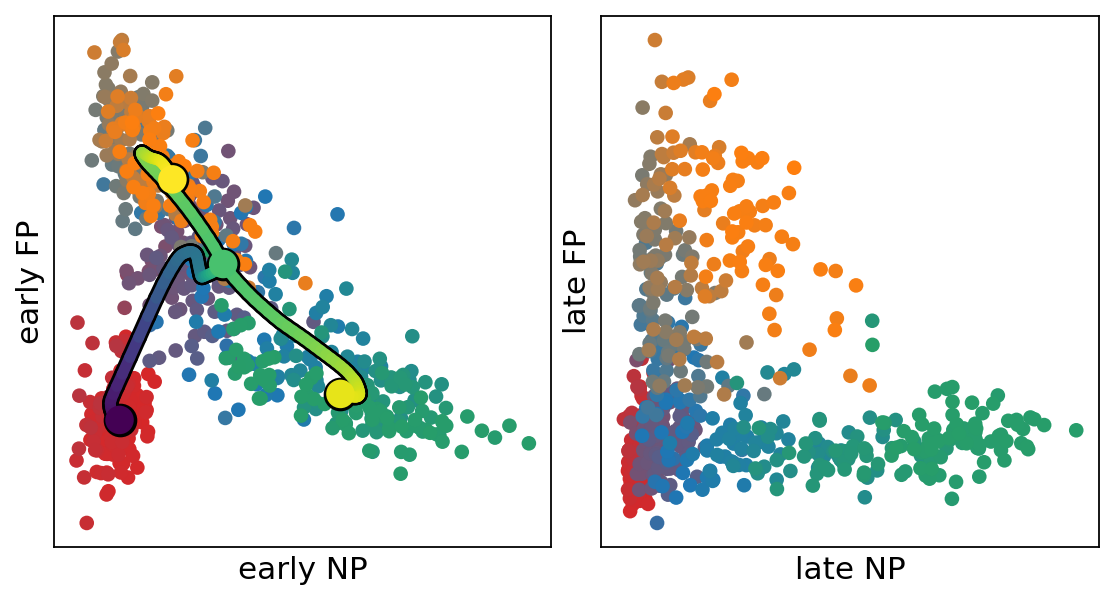

In [107]:
scf.pl.modules(adata, root_milestone="Root", milestones=["NP", "FP"],
               smooth=False, show_traj = True, module="all",save="_G_v3.pdf")

In [108]:
# extract the early and late modules
df=adata.uns["Root->NP<>FP"]["fork"].copy()
#df.index="\textit{"+df.index+"}"
eFP=df.index[(df.module=="early") & (df.branch=="FP")]
lFP=df.index[(df.module=="late") & (df.branch=="FP")]
eNP=df.index[(df.module=="early") & (df.branch=="NP")]
lNP=df.index[(df.module=="late") & (df.branch=="NP")]
import pandas as pd
dat=pd.DataFrame({'early FP': pd.Series(eFP), 
                  'late FP': pd.Series(lFP),
                  'early NP': pd.Series(eNP),
                  'late NP': pd.Series(lNP)})
dat=dat.fillna('')
dat

,early FP,late FP,early NP,late NP
0,Sox17,Sulf1,Pax6,Pou3f3
1,Prrx2,Peg3,Sox1,Zeb2
2,Hspa5,Cdkn1c,Irx3,Zfhx4
3,Mdk,Col4a2,Gas1,Sfrp2
4,Foxa2,Sox21,Nr2f1,Pou3f2
5,Gpc3,Sox4,,Hes5
6,Itgb1,Foxa1,,Peg12
7,Krt19,Vegfa,,Nkx6-2
8,Fzd2,Shh,,Plagl1
9,Hes1,,,Sfrp1


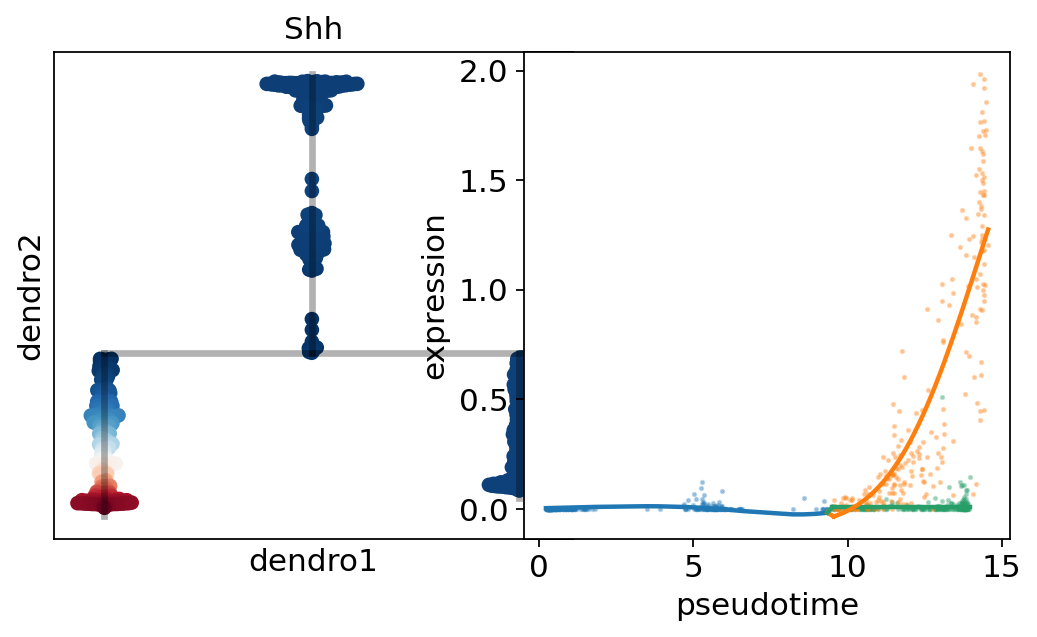

In [109]:
scf.pl.single_trend(adata,"Shh",basis="dendro",wspace=-.25)

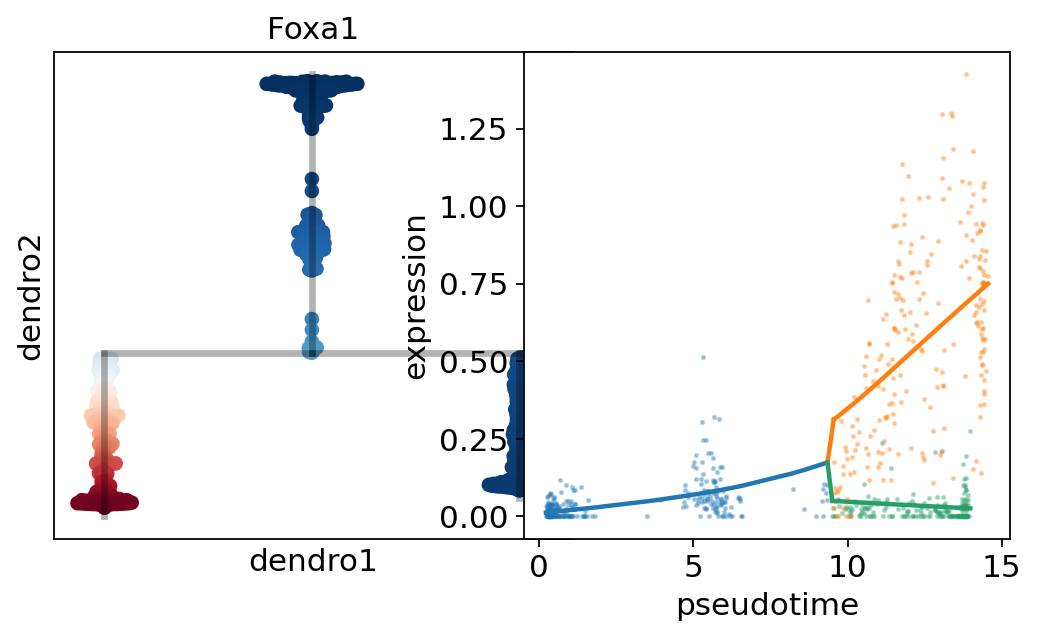

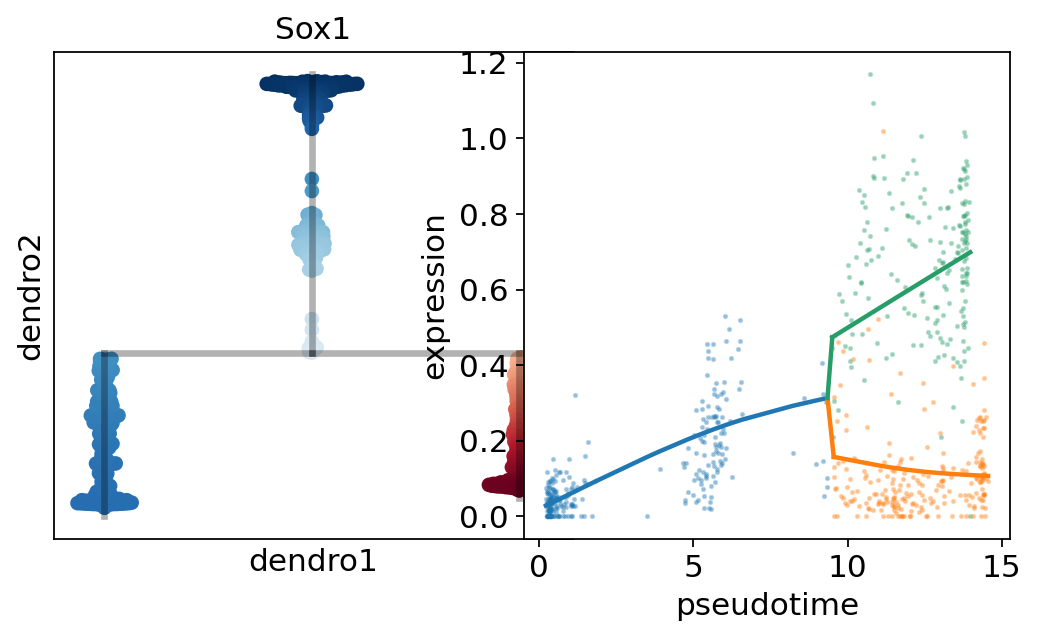

In [110]:
scf.pl.single_trend(adata,"Foxa1",basis="dendro",wspace=-.25)
scf.pl.single_trend(adata,"Sox1",basis="dendro",wspace=-.25)

In [111]:
# Repulsion of early gene modules
scf.tl.slide_cells(adata,root_milestone="Root", milestones=["NP", "FP"], win=90) # win parameter: number of cell per local pseudotime window.

--> added 
    .uns['Root->NP<>FP']['cell_freq'], probability assignment of cells on 8 non intersecting windows.


In [112]:
adata

AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [113]:
scf.tl.slide_cors(adata, root_milestone="Root", milestones=["NP", "FP"])

--> added 
    .uns['Root->NP<>FP']['corAB'], gene-gene correlation modules.


In [114]:
#adata.uns['Root->NP<>FP']['corAB']

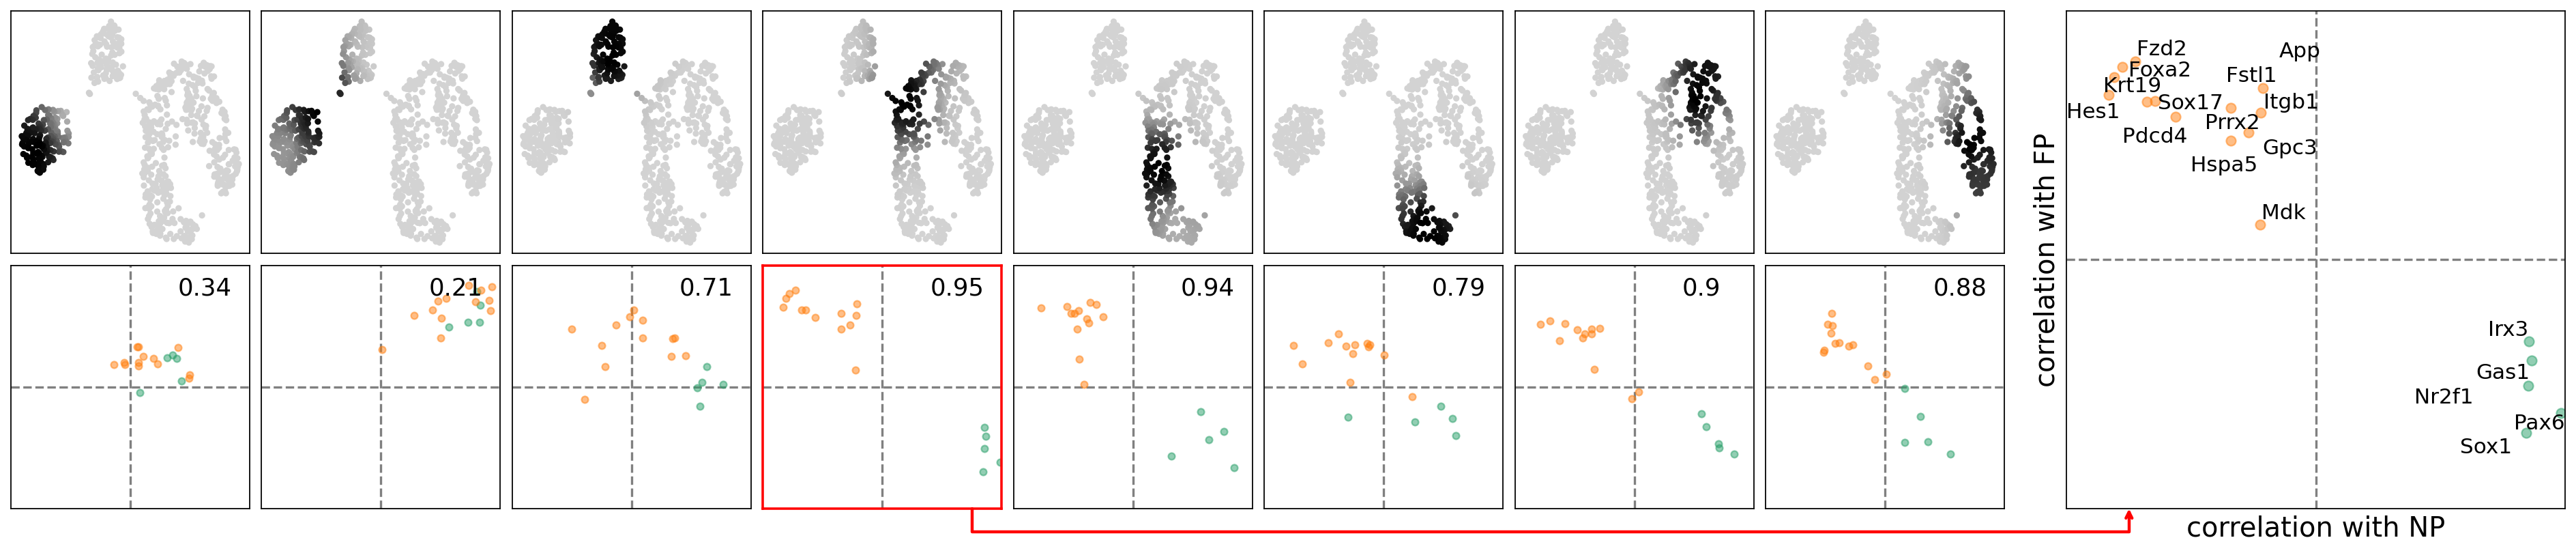

In [115]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"], 
                 win_keep=[0, 1, 2, 3, 4, 5, 6, 7],
                 focus=3, 
                 top_focus = 15, 
                 save="_H_save_test_window_8.pdf")

In [ ]:
### try to ajust the window number

In [99]:
# Repulsion of early gene modules
scf.tl.slide_cells(adata,root_milestone="Root", milestones=["NP", "FP"], win=62) # win parameter: number of cell per local pseudotime window.

--> added 
    .uns['Root->NP<>FP']['cell_freq'], probability assignment of cells on 12 non intersecting windows.


--> added 
    .uns['Root->NP<>FP']['corAB'], gene-gene correlation modules.


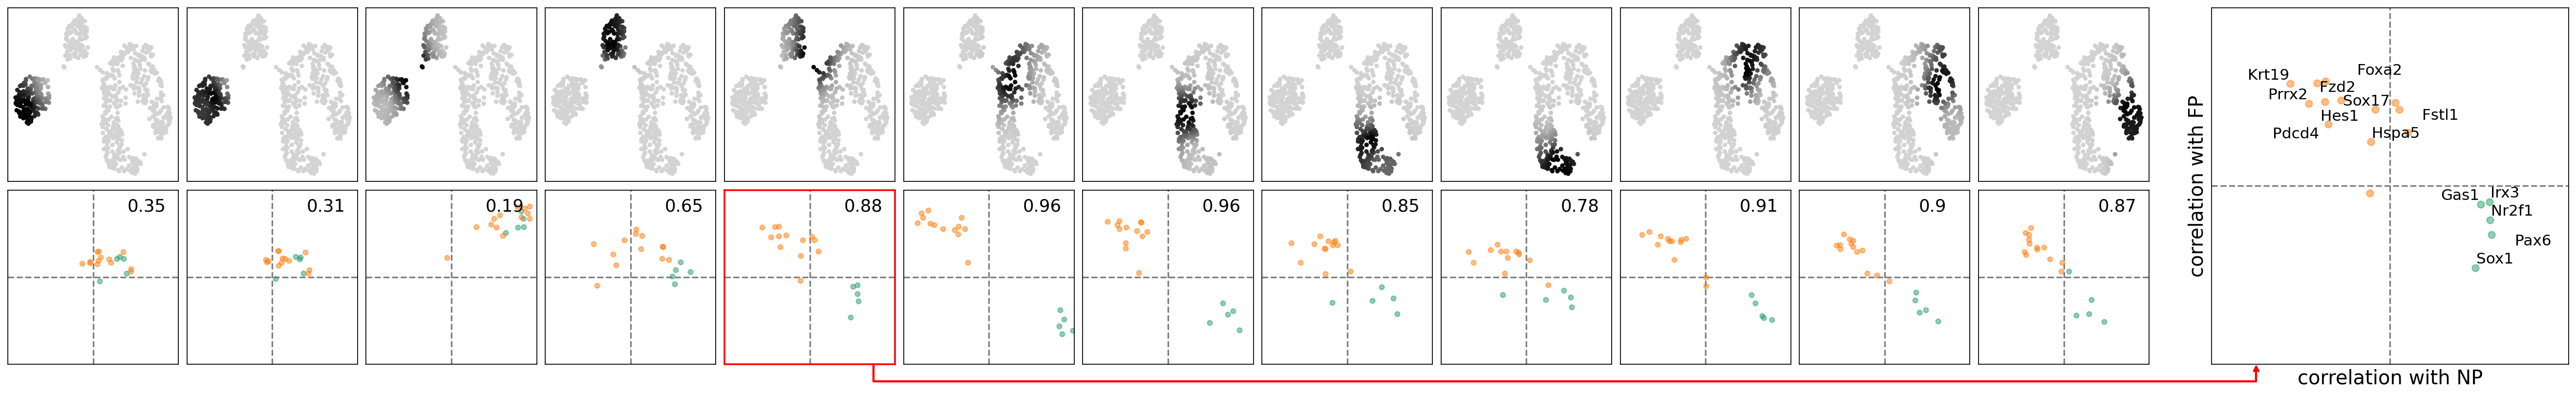

In [101]:
scf.tl.slide_cors(adata, root_milestone="Root", milestones=["NP", "FP"])
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"], 
                 win_keep=[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11],
                 focus=4, 
                 top_focus = 15, 
                 save="_H_save_test_v3.pdf")

In [114]:
## save the outputs for customized analysis

In [116]:
adata.write(os.path.join(outDir, 'scFates_pseudotime_mNT_d2.5_d5_localCorrelation_modules_2saved_window_8.h5ad'), compression="gzip")

In [117]:
adata = sc.read_h5ad(os.path.join(outDir, 'scFates_pseudotime_mNT_d2.5_d5_localCorrelation_modules_2saved_window_8.h5ad'),chunk_size=6000)

In [118]:
# Repulsion of early gene modules
#scf.tl.slide_cells(adata,root_milestone="Root",milestones=["NP", "FP"], win=1500) # win parameter: number of cell per local pseudotime window.

In [119]:
#scf.tl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"])

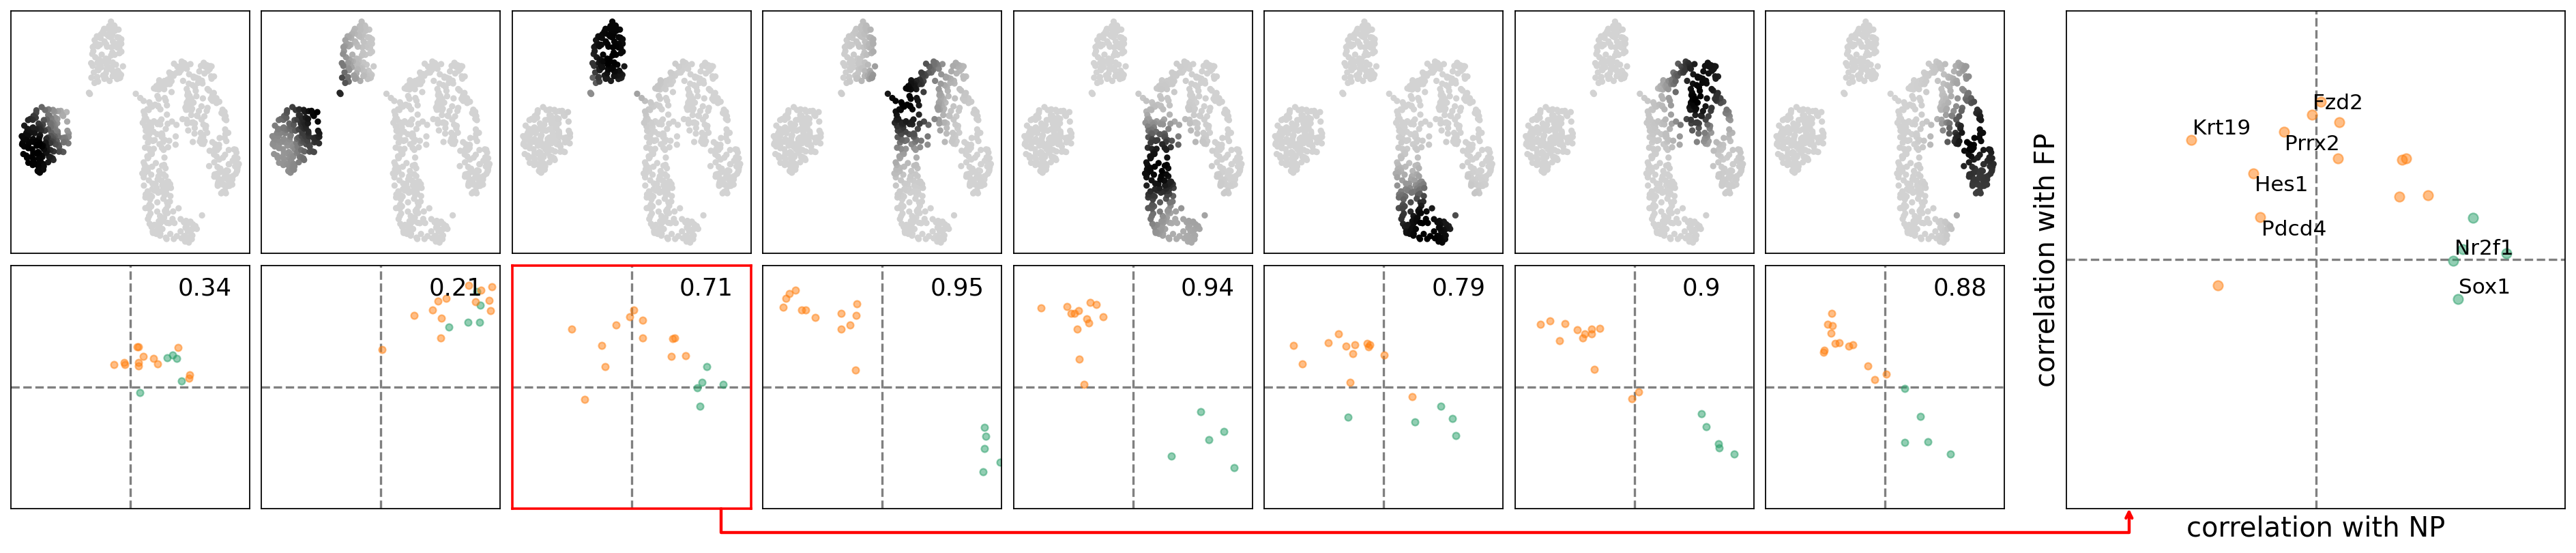

In [120]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"],basis="umap", 
                 win_keep=[0, 1, 2, 3, 4, 5, 6, 7],
                 focus=2, 
                 top_focus = 10, 
                 save="_H_save_v2.pdf")

In [121]:
adata

AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [122]:
df = pd.DataFrame(adata.X.A)
df

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,1.357942,0.266398,0.765736,0.011672,0.781981,0.912706,1.190709,1.425086,0.266398,1.549693,...,0.498185,0.573732,0.498185,0.352529,0.000000,0.000000,0.000000,0.121462,0.034616,0.000000
1,0.144846,0.383619,0.858768,0.014070,0.622900,1.121259,1.435622,1.401322,0.475786,1.380163,...,0.107377,0.681925,0.449017,0.068449,0.543854,0.068449,0.000000,1.093164,0.000000,0.041629
2,0.000000,0.000000,0.627224,1.220721,0.938114,1.259139,0.627224,1.009712,0.860991,1.928510,...,0.018788,0.786098,0.438251,0.000000,0.107770,0.235479,0.321581,0.000000,0.220379,0.018788
3,0.172717,0.561966,1.603759,0.024827,0.868171,0.631167,1.201528,1.046472,0.373266,1.802560,...,0.756674,0.072704,0.590224,0.714515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.287356,0.338601,0.674808,0.025942,0.831410,0.647675,0.932892,1.154553,0.416649,1.430326,...,0.525958,0.929439,0.461816,0.115689,0.115689,0.099959,0.008722,0.051228,0.000000,0.008722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,0.000000,0.325381,1.270806,0.000000,0.705812,0.277984,1.176579,0.980737,0.120611,1.654439,...,0.673657,0.062123,0.570481,0.413926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
691,0.000000,0.094313,1.318101,1.378034,0.751842,0.986322,1.155581,1.235358,1.134602,1.607254,...,0.032436,1.034331,0.444975,0.032436,0.000000,1.134602,0.000000,0.000000,0.564323,0.000000
692,0.000000,0.000000,1.027372,1.255958,0.793335,0.926105,0.793335,1.293556,0.852407,1.765249,...,0.000000,0.730553,0.514405,0.000000,0.000000,0.400969,0.085889,0.000000,0.164982,0.000000
693,0.000000,0.116450,1.170318,0.000000,0.687133,0.116450,1.494707,1.090586,0.401460,1.437706,...,0.315178,0.000000,0.315178,0.554463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [123]:
adata.var_names
adata.obs_names

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '686', '687', '688', '689', '690', '691', '692', '693', '694', '695'],
      dtype='object', length=695)

In [124]:
df.columns = adata.var_names
df.index = adata.obs_names

In [125]:
df

,Sox17,Sulf1,Terf1,Pou3f3,Wdr12,Serpine2,Kdm5b,Pbx1,Vangl2,Parp1,...,Hoxa5,Nr2f2,Hoxb2,Hoxb1,Shh,Nkx6-1,Dbx1,Igf1,Olig2,Arx
1,1.357942,0.266398,0.765736,0.011672,0.781981,0.912706,1.190709,1.425086,0.266398,1.549693,...,0.498185,0.573732,0.498185,0.352529,0.000000,0.000000,0.000000,0.121462,0.034616,0.000000
2,0.144846,0.383619,0.858768,0.014070,0.622900,1.121259,1.435622,1.401322,0.475786,1.380163,...,0.107377,0.681925,0.449017,0.068449,0.543854,0.068449,0.000000,1.093164,0.000000,0.041629
3,0.000000,0.000000,0.627224,1.220721,0.938114,1.259139,0.627224,1.009712,0.860991,1.928510,...,0.018788,0.786098,0.438251,0.000000,0.107770,0.235479,0.321581,0.000000,0.220379,0.018788
4,0.172717,0.561966,1.603759,0.024827,0.868171,0.631167,1.201528,1.046472,0.373266,1.802560,...,0.756674,0.072704,0.590224,0.714515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.287356,0.338601,0.674808,0.025942,0.831410,0.647675,0.932892,1.154553,0.416649,1.430326,...,0.525958,0.929439,0.461816,0.115689,0.115689,0.099959,0.008722,0.051228,0.000000,0.008722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,0.000000,0.325381,1.270806,0.000000,0.705812,0.277984,1.176579,0.980737,0.120611,1.654439,...,0.673657,0.062123,0.570481,0.413926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
692,0.000000,0.094313,1.318101,1.378034,0.751842,0.986322,1.155581,1.235358,1.134602,1.607254,...,0.032436,1.034331,0.444975,0.032436,0.000000,1.134602,0.000000,0.000000,0.564323,0.000000
693,0.000000,0.000000,1.027372,1.255958,0.793335,0.926105,0.793335,1.293556,0.852407,1.765249,...,0.000000,0.730553,0.514405,0.000000,0.000000,0.400969,0.085889,0.000000,0.164982,0.000000
694,0.000000,0.116450,1.170318,0.000000,0.687133,0.116450,1.494707,1.090586,0.401460,1.437706,...,0.315178,0.000000,0.315178,0.554463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [126]:
df.to_csv(os.path.join(outDir, "annData_geneExpr_metacells_v2.csv"), index=True, header=True)

In [127]:
df = adata.obs[["t", 'seg', 't_sd', 'milestones']]
df.index = adata.obs_names
df

,t,seg,t_sd,milestones
1,10.200403,1,1.455597,Bifu
2,12.613487,1,1.041921,FP
3,13.693856,2,0.536108,NP
4,0.391121,3,0.900856,Root
5,11.515157,1,0.958890,Bifu
...,...,...,...,...
691,0.500030,3,0.498126,Root
692,13.846636,2,0.621063,NP
693,13.792997,2,0.500174,NP
694,0.699266,3,0.696788,Root


In [128]:
df.to_csv(os.path.join(outDir, "annData_pseudotime_segments_milestones_v2.csv"), index=True, header=True)

In [129]:
#scf.tl.slide_cells(adata,root_milestone="Root",milestones=["NP", "FP"], win=1500, copy = False) 

In [130]:
adata

AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [131]:
df = adata.uns['Root->NP<>FP']['cell_freq']

In [132]:
df = pd.DataFrame(df)
df.columns = adata.obs_names

In [133]:
df

,1,2,3,4,5,6,7,8,9,10,...,686,687,688,689,690,691,692,693,694,695
0,0.000013,3.860980e-07,0.000030,7.334051e-01,9.515060e-07,0.000041,5.579123e-01,1.227398e-07,6.115281e-01,0.000011,...,1.887204e-07,7.544920e-01,3.696630e-07,0.000402,7.206818e-01,5.761173e-01,0.000003,0.000004,4.599038e-01,0.000011
1,0.001017,1.897197e-05,0.000104,3.026452e-01,4.441016e-05,0.000127,4.893411e-01,3.616700e-06,4.292728e-01,0.000092,...,7.201045e-06,2.794093e-01,4.825622e-06,0.060112,3.139690e-01,4.625573e-01,0.000016,0.000021,5.730866e-01,0.000562
2,0.025569,4.057852e-04,0.000113,7.394827e-04,8.657087e-04,0.000118,1.187579e-03,5.661441e-05,1.281920e-03,0.000324,...,1.342476e-04,6.787617e-04,3.846917e-05,0.859699,9.610200e-04,1.675640e-03,0.000042,0.000043,3.044060e-03,0.009898
3,0.589205,4.311895e-02,0.004707,8.819328e-05,1.045315e-01,0.004520,1.190359e-04,8.878979e-03,1.015227e-04,0.028733,...,1.805232e-02,8.569434e-05,6.499996e-03,0.111399,6.981675e-05,1.223336e-04,0.004315,0.002960,2.051518e-04,0.754947
4,0.029048,8.547686e-03,0.265079,4.393810e-05,1.529687e-02,0.250954,4.377917e-05,6.108248e-03,3.015986e-05,0.680075,...,6.844884e-03,4.870326e-05,3.211501e-02,0.001707,2.253189e-05,3.270738e-05,0.168613,0.184717,4.653700e-05,0.053173
5,0.000983,1.274656e-03,0.756598,9.859178e-06,1.246056e-03,0.769378,8.178764e-06,2.356813e-03,5.289855e-06,0.294899,...,1.785741e-03,1.196531e-05,4.221980e-02,0.000053,4.507491e-06,5.466108e-06,0.799986,0.832156,7.022210e-06,0.001708
6,0.379526,5.287275e-01,0.001108,2.221089e-06,7.797269e-01,0.001048,2.764668e-06,1.087210e-01,2.177038e-06,0.009530,...,2.526386e-01,2.227836e-06,2.677490e-02,0.002950,1.483379e-06,2.541117e-06,0.003829,0.001071,4.100368e-06,0.205968
7,0.024747,4.440578e-01,0.002445,3.614920e-07,1.293572e-01,0.002424,4.024193e-07,7.727140e-01,2.940350e-07,0.014937,...,6.877918e-01,3.815798e-07,5.870043e-01,0.000183,2.061466e-07,3.309758e-07,0.031458,0.003066,5.055946e-07,0.015471


In [134]:
df.to_csv(os.path.join(outDir, "annData_cellAssignment_to_nonIntersectingWindows_8_v2.csv"), index=True, header=True)

In [136]:
adata

AnnData object with n_obs × n_vars = 695 × 228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'size', 'condition', 'S.Score', 'G2M.Score', 'Phase', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [138]:
adata.X.copy()


<695x228 sparse matrix of type '<class 'numpy.float64'>'
	with 145214 stored elements in Compressed Sparse Row format>

In [140]:
adata.X[1:10, 1:10].todense()

matrix([[0.38361911, 0.85876805, 0.01406984, 0.62289974, 1.12125902,
         1.435622  , 1.40132217, 0.47578636, 1.38016297],
        [0.        , 0.62722374, 1.22072115, 0.93811362, 1.25913933,
         0.62722374, 1.00971191, 0.86099093, 1.92850986],
        [0.56196587, 1.6037589 , 0.02482651, 0.8681708 , 0.63116737,
         1.20152849, 1.04647226, 0.37326589, 1.80256022],
        [0.33860077, 0.67480769, 0.02594208, 0.83140992, 0.64767496,
         0.93289157, 1.15455292, 0.41664878, 1.4303262 ],
        [0.02908526, 0.53549686, 0.93005284, 0.68001539, 0.8062613 ,
         0.51806999, 0.72389228, 0.61834747, 1.53256144],
        [0.65946641, 1.78712762, 0.        , 0.66548417, 0.39106331,
         1.59129857, 1.28496145, 0.30022316, 1.81412111],
        [0.67938376, 0.35170333, 0.        , 0.35170333, 0.87302762,
         1.23304245, 1.61993407, 0.89975175, 1.50442893],
        [0.39131246, 1.48132972, 0.        , 0.67184238, 0.41198954,
         1.31760907, 1.05945005, 0.2453612